In [ ]:
import pandas as pd
import numpy as np
import itertools as it

Мы знаем, как рассчитать необходимый объём выборок. Теперь нужно правильно выбрать пользователей для эксперимента.

## A/A-тесты
* A/A-тест помогает удостовериться в том, что разделение выборок происходит корректно
* Позволяет определить уровень значимости для A/B-теста
* В целом проверяет надёжность работы системы тестов

Нулевая и альтернативная гипотезы берутся такие же как для A/B теста. Возьмём контрольную группу из датасета cookie cats с прошлой лекции на роль исторических данных.

In [3]:
data = pd.read_csv("../data/cookie_cats.csv")
data = data[data['version'] == 'gate_30'].drop(columns=['version']).reset_index(drop=True)
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
data

,userid,sum_gamerounds,retention_1,retention_7
0,116,3,False,False
1,337,38,True,False
2,1066,0,False,False
3,2101,0,False,False
4,2179,39,True,False
...,...,...,...,...
44695,9998576,14,True,False
44696,9998623,7,False,False
44697,9999178,21,True,False
44698,9999349,10,False,False


Задача: разбить пользователей на две группы для A/B-тестирования.

Разобьём пользователей на группы, как сделали бы, готовя проведение A/B-тестирования

In [4]:
a1 = data.sample(frac = 0.55)
a2 = data.drop(a1.index)

len(a1), len(a2)

(24584, 20115)

Если у нас есть представления о том, какое разбиение хотелось получить, и неизвестно, какое получено в реальности, можно выполнить проверку на SRM — Sample Rate Mismatch, отклонение фактического разбиения от ожидаемого. Здесь приведён [$\chi^2$-критерий](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%85%D0%B8-%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82). Если p-value *достаточно близко к 1*, разбиение не соответствует ожидаемому и нужно его переделать, чтобы правильно провести эксперимент.

In [5]:
from scipy.stats import chisquare

chi = chisquare([len(a1), len(a2)], f_exp = [24600, 20099])
chi

Power_divergenceResult(statistic=0.02314345615220917, pvalue=0.8790846123238008)

In [6]:
print("Разбиение достаточно близко к желаемому") if chi.pvalue < 0.95 else print("Разбиение сильно отдичается от желаемого")

Разбиение достаточно близко к желаемому


На практике необходимо продолжительноее наблюдение за выборками, чтобы убедиться, что выбранный для A/B-теста критерий не показывает устойчивой статзначимости различия метрик (разовое опровержение $H_0$ ещё не показательно). Обычно это занимает около месяца. Так как у нас нет данных о продолжительном наблюдении, проведём бутстрапирование: делаем множество разбиений и для каждого проводим t-test.

In [7]:
from scipy.stats import ttest_ind
from tqdm import tqdm

p_values = []

for a in tqdm(range(10000)):
    a1 = data.sample(frac = 0.55)
    a2 = data.drop(a1.index)
    test = ttest_ind(a1['sum_gamerounds'], a2['sum_gamerounds'], equal_var=False)
    p_values.append(test.pvalue)

100%|██████████| 10000/10000 [04:54<00:00, 33.92it/s]


Text(0.5, 0, 'P-value')

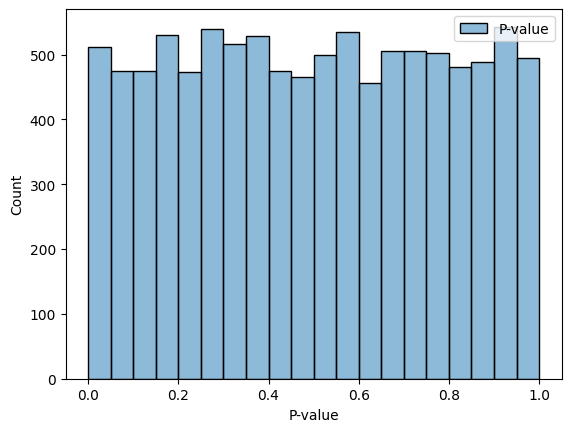

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=pd.DataFrame(p_values, columns=['P-value']), bins=20)
plt.xlabel("P-value")

Для заключения об успехе A/A теста полученное распределение полученных p-значений должно быть равномерным. Для проверки равномерности используем критерий Колмогорова-Смирнова

In [9]:
from scipy.stats import kstest

ks = kstest(p_values,"uniform")
ks

KstestResult(statistic=0.005273644054865634, pvalue=0.9423055883954099, statistic_location=0.13587364405486563, statistic_sign=-1)

In [10]:
print("Распределение равномерно") if ks.pvalue > 0.05 else print("Распределение не равномерно")

Распределение равномерно


Также две выборки должны быть **гомогенны** (однородны), то есть, должны принадлежать одному распределению. Выберем разбиение, для которого по t-тесту средние равны.

In [11]:
for i in tqdm(range(1000)):
    a1 = data.sample(frac = 0.55)
    a2 = data.drop(a1.index)
    test = ttest_ind(a1['sum_gamerounds'], a2['sum_gamerounds'], equal_var=False)
    if (test.pvalue >= 0.05):
        break

  0%|          | 0/1000 [00:00<?, ?it/s]


In [12]:
test

TtestResult(statistic=0.3944223890390581, pvalue=0.6932711555077413, df=43383.29539171074)

Нашли разбиение, для которого A/A-тест подтвердил нулевую гипотезу, можно использовать для A/B.

## A/B/C-тесты

В некоторых ситуациях может понадобиться одновременно протестировать несколько гипотез.

Эксперимент: магазин одежды отправлял клиентам почтовую рассылку с рекламой женской одежды, мужской одежды или не отправлял рассылку вообще. Будем оценивать суммы, потраченные этими пользователями на сайте за год.

In [13]:
data = pd.read_csv("../data/MineThatData.csv")
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail
...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail


Рассмотрим только группу клиентов из сельской местности (для неё более показательные результаты)

In [15]:
data = data[data.zip_code == 'Rural']

In [16]:
data['segment'].value_counts()

segment
Mens E-Mail      3243
Womens E-Mail    3181
No E-Mail        3139
Name: count, dtype: int64

In [17]:
data = data[['segment', 'history']]
data

,segment,history
1,No E-Mail,329.08
3,Mens E-Mail,675.83
8,Mens E-Mail,675.07
14,No E-Mail,241.42
17,Mens E-Mail,112.35
...,...,...
63949,No E-Mail,86.79
63951,Womens E-Mail,50.94
63952,No E-Mail,29.99
63958,Womens E-Mail,65.82


In [18]:
data.groupby('segment').history.mean()

segment
Mens E-Mail      238.224607
No E-Mail        250.424944
Womens E-Mail    240.102446
Name: history, dtype: float64

Растёт вероятность ошибки для независимых p-value, поэтому поднимается уровень значимости (false positive): $1 - (1 - \alpha)^n$, где n для A/B/.../N теста $n=\binom{N}{2}$

In [24]:
# слишком высокая альфа для настоящего эксперимента
alpha = 0.2
1 - (1 - alpha) ** 3

0.4879999999999999

Поправка Бонферрони: $\alpha* = \frac{\alpha}{n}$

In [25]:
bonferroni_alpha = alpha / 3
bonferroni_alpha

0.06666666666666667

Более чувствительная и более сложная поправка Бенджамини-Хохберга:<br>
1. Сортируем p-значения по возрастанию и присваиваем им индексы<br>
$p_1\leq p_2\leq ...\leq p_n$<br>
2. Находим p с наибольшим рангом $j*$ такое, что:<br>
$p_j\leq q$; $q = \gamma \frac{j}{n}$<br>
3. Все тесты с рангом $j < j*$ — статзначимые

Сравним результаты с двумя этими поправками.

In [26]:
def p(col1, col2):
    return ttest_ind(
        data[data.segment == col1].history.reset_index(drop=True),
        data[data.segment == col2].history.reset_index(drop=True), equal_var=False).pvalue

gamma = 0.1
segments = data.segment.unique()
df = pd.DataFrame(np.array(list(it.combinations(segments, 2))), columns=['seg1', 'seg2'])
df['p'] = df.apply(lambda x: p(x['seg1'], x['seg2']), axis=1)
df = df.sort_values(by=['p'])
df['q'] = gamma * (df.index + 1) / len(df)
df['p_corrected_BH'] = gamma * df['p'] ** len(df) / df['q']
df['BH'] = df['p_corrected_BH'] < alpha
df['bonferroni'] = df['p'] < bonferroni_alpha
df

,seg1,seg2,p,q,p_corrected_BH,BH,bonferroni
0,No E-Mail,Mens E-Mail,0.056732,0.033333,0.000548,True,True
1,No E-Mail,Womens E-Mail,0.107345,0.066667,0.001855,True,False
2,Mens E-Mail,Womens E-Mail,0.763290,0.100000,0.444702,False,False
